# Espacios de color RGB y CIE

**Curso**: CC5213 - Recuperación de Información Multimedia  
**Profesor**: Juan Manuel Barrios  
**Fecha**: 24 de marzo de 2025

En este ejemplo se muestra cómo calcular distancia entre colores en el espacio RGB y en los espacios CIE LAB y CIE LUV.


### Algunas funciones auxiliares para convertir entre espacios de color

In [ ]:
import numpy
import cv2
import math 

# representa un color como rgb y lo convierte a cielab o cieluv
class Color:
    def __init__(self, nombre, r, g, b):
        self.nombre = nombre
        self.r = r
        self.g = g
        self.b = b

    def rgb(self):
        return (self.r, self.g, self.b)
        
    def bgr(self):
        return (self.b, self.g, self.r)
        
    def cielab(self):
        imagen_pixel_bgr = numpy.zeros((1, 1, 3), numpy.float32)
        imagen_pixel_bgr[0][0] = (self.b / 255, self.g / 255, self.r / 255)
        imagen_pixel_lab = cv2.cvtColor(imagen_pixel_bgr, cv2.COLOR_BGR2Lab)
        lab = imagen_pixel_lab[0][0]
        print("{} l={:.3f} a={:.3f} b={:.3f}".format(self.nombre, lab[0], lab[1], lab[2]))
        return lab

    def cieluv(self):
        imagen_pixel_bgr = numpy.zeros((1, 1, 3), numpy.float32)
        imagen_pixel_bgr[0][0] = (self.b / 255, self.g / 255, self.r / 255)
        imagen_pixel_luv = cv2.cvtColor(imagen_pixel_bgr, cv2.COLOR_BGR2Luv)
        lab = imagen_pixel_luv[0][0]
        return lab


def cuadriculado(imagen, size_cuadros=4, cuadro_color1=(0, 0, 0), cuadro_color2=(255, 255, 255)):
    flag1 = True
    for y in range(0, imagen.shape[0], size_cuadros):
        flag2 = not flag1
        for x in range(0, imagen.shape[1], size_cuadros):
            tl = (x, y)
            br = (x + size_cuadros, y + size_cuadros)
            col = cuadro_color1 if flag2 else cuadro_color2
            cv2.rectangle(imagen, tl, br, col, -1)
            flag2 = not flag2
        flag1 = not flag1

    
def agregar_texto(imagen, texto, posicion_centro):
    fontFace = cv2.FONT_HERSHEY_PLAIN
    fontScale = 0.8
    fontThickness = 1
    ((text_w, text_h), baseline_h) = cv2.getTextSize(texto, fontFace, fontScale, fontThickness)
    padding = (5, 5)
    tl = (int(posicion_centro[0] - text_w / 2 - padding[0]), 
          int(posicion_centro[1] - text_h / 2 - padding[1]))
    br = (int(tl[0] + text_w + 2*padding[0]),
          int(tl[1] + text_h + baseline_h/4 + 2*padding[1]))
    cv2.rectangle(imagen, tl, br, (100, 100, 100), -1)
    pos = (int(posicion_centro[0] - text_w / 2), 
           int(posicion_centro[1] + text_h / 2))
    fontColor = (220, 250, 250)
    cv2.putText(imagen, texto, pos, fontFace, fontScale, fontColor, fontThickness, cv2.LINE_AA)


# Comparar colores con distancia euclidiana

Se comparan entre sí los colores en los 8 vértices del cubo RGB: rojo, verde, azul, magenta, amarillo, cyan, blanco, negro.

La idea es ver la diferencia entre las distancias en el cubo RGB con las distancias en CIR LAB Y CIE LUV.

In [ ]:
# representa la matriz de distancias
class MatrizDistancias:
    def __init__(self, nombre, colores1, colores2, funcion_distancia, mitad_matriz):
        self.nombre = nombre
        self.colores1 = colores1
        self.colores2 = colores2
        # inicializo con distancias -1
        self.dist_matrix = numpy.full((len(colores1), len(colores2)), -1, numpy.float32)
        for i in range(0, len(colores1)):
            # en matrices simetricas calcular unicamente sobre la diagonal
            j_desde = i + 1 if mitad_matriz else 0
            for j in range(j_desde, len(colores2)):
                self.dist_matrix[i][j] = funcion_distancia(colores1[i], colores2[j])

    def imprimir_distancia_maxima(self):
        print()
        val_max = numpy.max(self.dist_matrix)
        for i in range(0, len(self.colores1)):
            for j in range(0, len(self.colores2)):
                if self.dist_matrix[i][j] >= val_max:
                    print("MAX distance {}={:.2f} ({}, {})".format(self.nombre, self.dist_matrix[i][j], self.colores1[i].nombre, self.colores2[j].nombre))
        # también se imprimen los que están cerca del máximo        
        cerca_max = val_max * 0.95
        for i in range(0, len(self.colores1)):
            for j in range(i, len(self.colores2)):
                if cerca_max < self.dist_matrix[i][j] < val_max:
                    print("  -CERCA_MAX {}={:.2f} ({}, {})".format(self.nombre, self.dist_matrix[i][j], self.colores1[i].nombre, self.colores2[j].nombre))


    def imagen_celdas_distancias(self, block_size):
        imagen_height = len(self.colores1) * block_size
        imagen_width = len(self.colores2) * block_size
        imagen = numpy.zeros((imagen_height, imagen_width, 3), numpy.uint8)
        cuadriculado(imagen, cuadro_color1=(80, 80, 80), cuadro_color2=(170, 170, 170))
        # en un ColorJet se crea una imagen gris y luego se convierte a una escala de colores con la función cv2.applyColorMap()
        val_max = numpy.max(self.dist_matrix)
        for i in range(0, len(self.colores1)):
            for j in range(0, len(self.colores2)):
                if self.dist_matrix[i][j] < 0:
                    continue
                # la distancia máxima (colores menos parecidos) será 0 y el mínimo (más parecidos) será 255 (escala lineal)
                valor_gris = int((1 - (self.dist_matrix[i][j] / val_max)) * 255)
                gris_celda = (valor_gris, valor_gris, valor_gris)
                tl = (int(j * block_size), 
                      int(i * block_size))
                br = (int((j+1) * block_size - 1), 
                      int((i+1) * block_size - 1))
                cv2.rectangle(imagen, tl, br, gris_celda, -1)
        # se cambian los grises por escala de colores (0=azul, 255=rojo)
        # ver https://docs.opencv.org/4.10.0/d3/d50/group__imgproc__colormap.html#ga9a805d8262bcbe273f16be9ea2055a65.
        imagen = cv2.applyColorMap(imagen, cv2.COLORMAP_JET)
        # se imprime el valor de la distancia en el centro de la celda
        for i in range(0, len(self.colores1)):
            for j in range(0, len(self.colores2)):
                if self.dist_matrix[i][j] < 0:
                    continue
                texto = "{:3.1f}".format(self.dist_matrix[i][j])
                posicion = (j * block_size + block_size/2, i * block_size + block_size/2)
                agregar_texto(imagen, texto, posicion)
        # lineas separadoras entre recuadros
        for i in range(0, len(self.colores1)):
            tl = (0, int(i * block_size))
            tr = (imagen.shape[1], int(i * block_size))
            cv2.line(imagen, tl, tr, (0,0,0), 1)
        for j in range(0, len(self.colores2)):
            tl = (int(j*block_size), 0)
            tr = (int(j*block_size), imagen.shape[0])
            cv2.line(imagen, tl, tr, (0,0,0), 1)
        return imagen

    def crear_imagen_distancias(self, block_size):
        imagen_height = (len(self.colores1) + 1) * block_size
        imagen_width = (len(self.colores2) + 1) * block_size
        imagen = numpy.zeros((imagen_height, imagen_width, 3), numpy.uint8)
        cuadriculado(imagen, cuadro_color1=(0, 192, 255), cuadro_color2=(255, 212, 0))
        # primera columna, recuadros de colores 1
        for i in range(0, len(self.colores1)):
            tl = (0, (i+1) * block_size)
            br = (block_size - 1, (i+2) * block_size - 1)
            cv2.rectangle(imagen, tl, br, self.colores1[i].bgr(), -1)
        # primera fila, recuadros de colores 2
        for j in range(0, len(self.colores2)):
            tl = ((j+1) * block_size, 0)
            br = ((j+2) * block_size - 1, block_size - 1)
            cv2.rectangle(imagen, tl, br, self.colores2[j].bgr(), -1)
        # matriz de distancias
        img2 = self.imagen_celdas_distancias(block_size)
        imagen[block_size:block_size+img2.shape[0], block_size:block_size+img2.shape[1]] = img2
        # linea separadora horizontal entre colores y matriz
        tl = (0, block_size)
        tr = (imagen.shape[1], block_size)
        cv2.line(imagen, tl, tr, (0,0,0), 2)
        # linea separadora vertical entre colores y matriz
        tr = (block_size, 0)
        br = (block_size, imagen.shape[0])
        cv2.line(imagen, tr, br, (0,0,0), 2)
        return imagen

def distancia_euclidiana(c1, c2):
    # se hace el calculo a mano (se podría usar alguna función de numpy)
    diff1 = (c1[0] - c2[0])
    diff2 = (c1[1] - c2[1])
    diff3 = (c1[2] - c2[2])
    dist = math.sqrt(diff1 * diff1 + diff2 * diff2 + diff3 * diff3)
    return dist

def distancia_rgb(color1, color2):
    return distancia_euclidiana(color1.rgb(), color2.rgb())

def distancia_cielab(color1, color2):
    return distancia_euclidiana(color1.cielab(), color2.cielab())

def distancia_cieluv(color1, color2):
    return distancia_euclidiana(color1.cieluv(), color2.cieluv())

def comparar_colores(colores1, colores2 = None, block_size = 80):
    # si se comparan los mismos colores, mostrar solo la mitad porque es simétrica
    mitad_matriz = False
    if colores2 is None:
        colores2 = colores1
        mitad_matriz = True
    
    dmatrix_rgb = MatrizDistancias("RGB", colores1, colores2, distancia_rgb, mitad_matriz)
    dmatrix_rgb.imprimir_distancia_maxima()
    imagen_rgb = dmatrix_rgb.crear_imagen_distancias(block_size)

    dmatrix_lab = MatrizDistancias("CIELAB", colores1, colores2, distancia_cielab, mitad_matriz)
    dmatrix_lab.imprimir_distancia_maxima()
    imagen_lab = dmatrix_lab.crear_imagen_distancias(block_size)
    
    dmatrix_luv = MatrizDistancias("CIELUV", colores1, colores2, distancia_cieluv, mitad_matriz)
    dmatrix_luv.imprimir_distancia_maxima()    
    imagen_luv = dmatrix_luv.crear_imagen_distancias(block_size)

    # mostrar imagenes
    cv2.imshow("DISTANCIAS_RGB", imagen_rgb)
    cv2.imshow("DISTANCIAS_CIELAB", imagen_lab)
    cv2.imshow("DISTANCIAS_CIELUV", imagen_luv)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def ejemplo_1():
    # los 8 vértices del cubo rgb
    lista = list()
    lista.append(Color("negro",      0,   0,   0))
    lista.append(Color("azul",       0,   0, 255))
    lista.append(Color("verde",      0, 255,   0))
    lista.append(Color("rojo",     255,   0,   0))
    lista.append(Color("cyan",       0, 255, 255))
    lista.append(Color("magenta",  255,   0, 255))
    lista.append(Color("amarillo", 255, 255,   0))
    lista.append(Color("blanco",   255, 255, 255))
    # se comparan entre si
    comparar_colores(lista, block_size = 60)


ejemplo_1()

# Comparación

Notar como cambian las distancias al compararlos los colores en los espacios RGB, CIE LAB y CIE LUV.

**¿Cuál espacio se parece más a lo que diría una persona al comparar colores?**

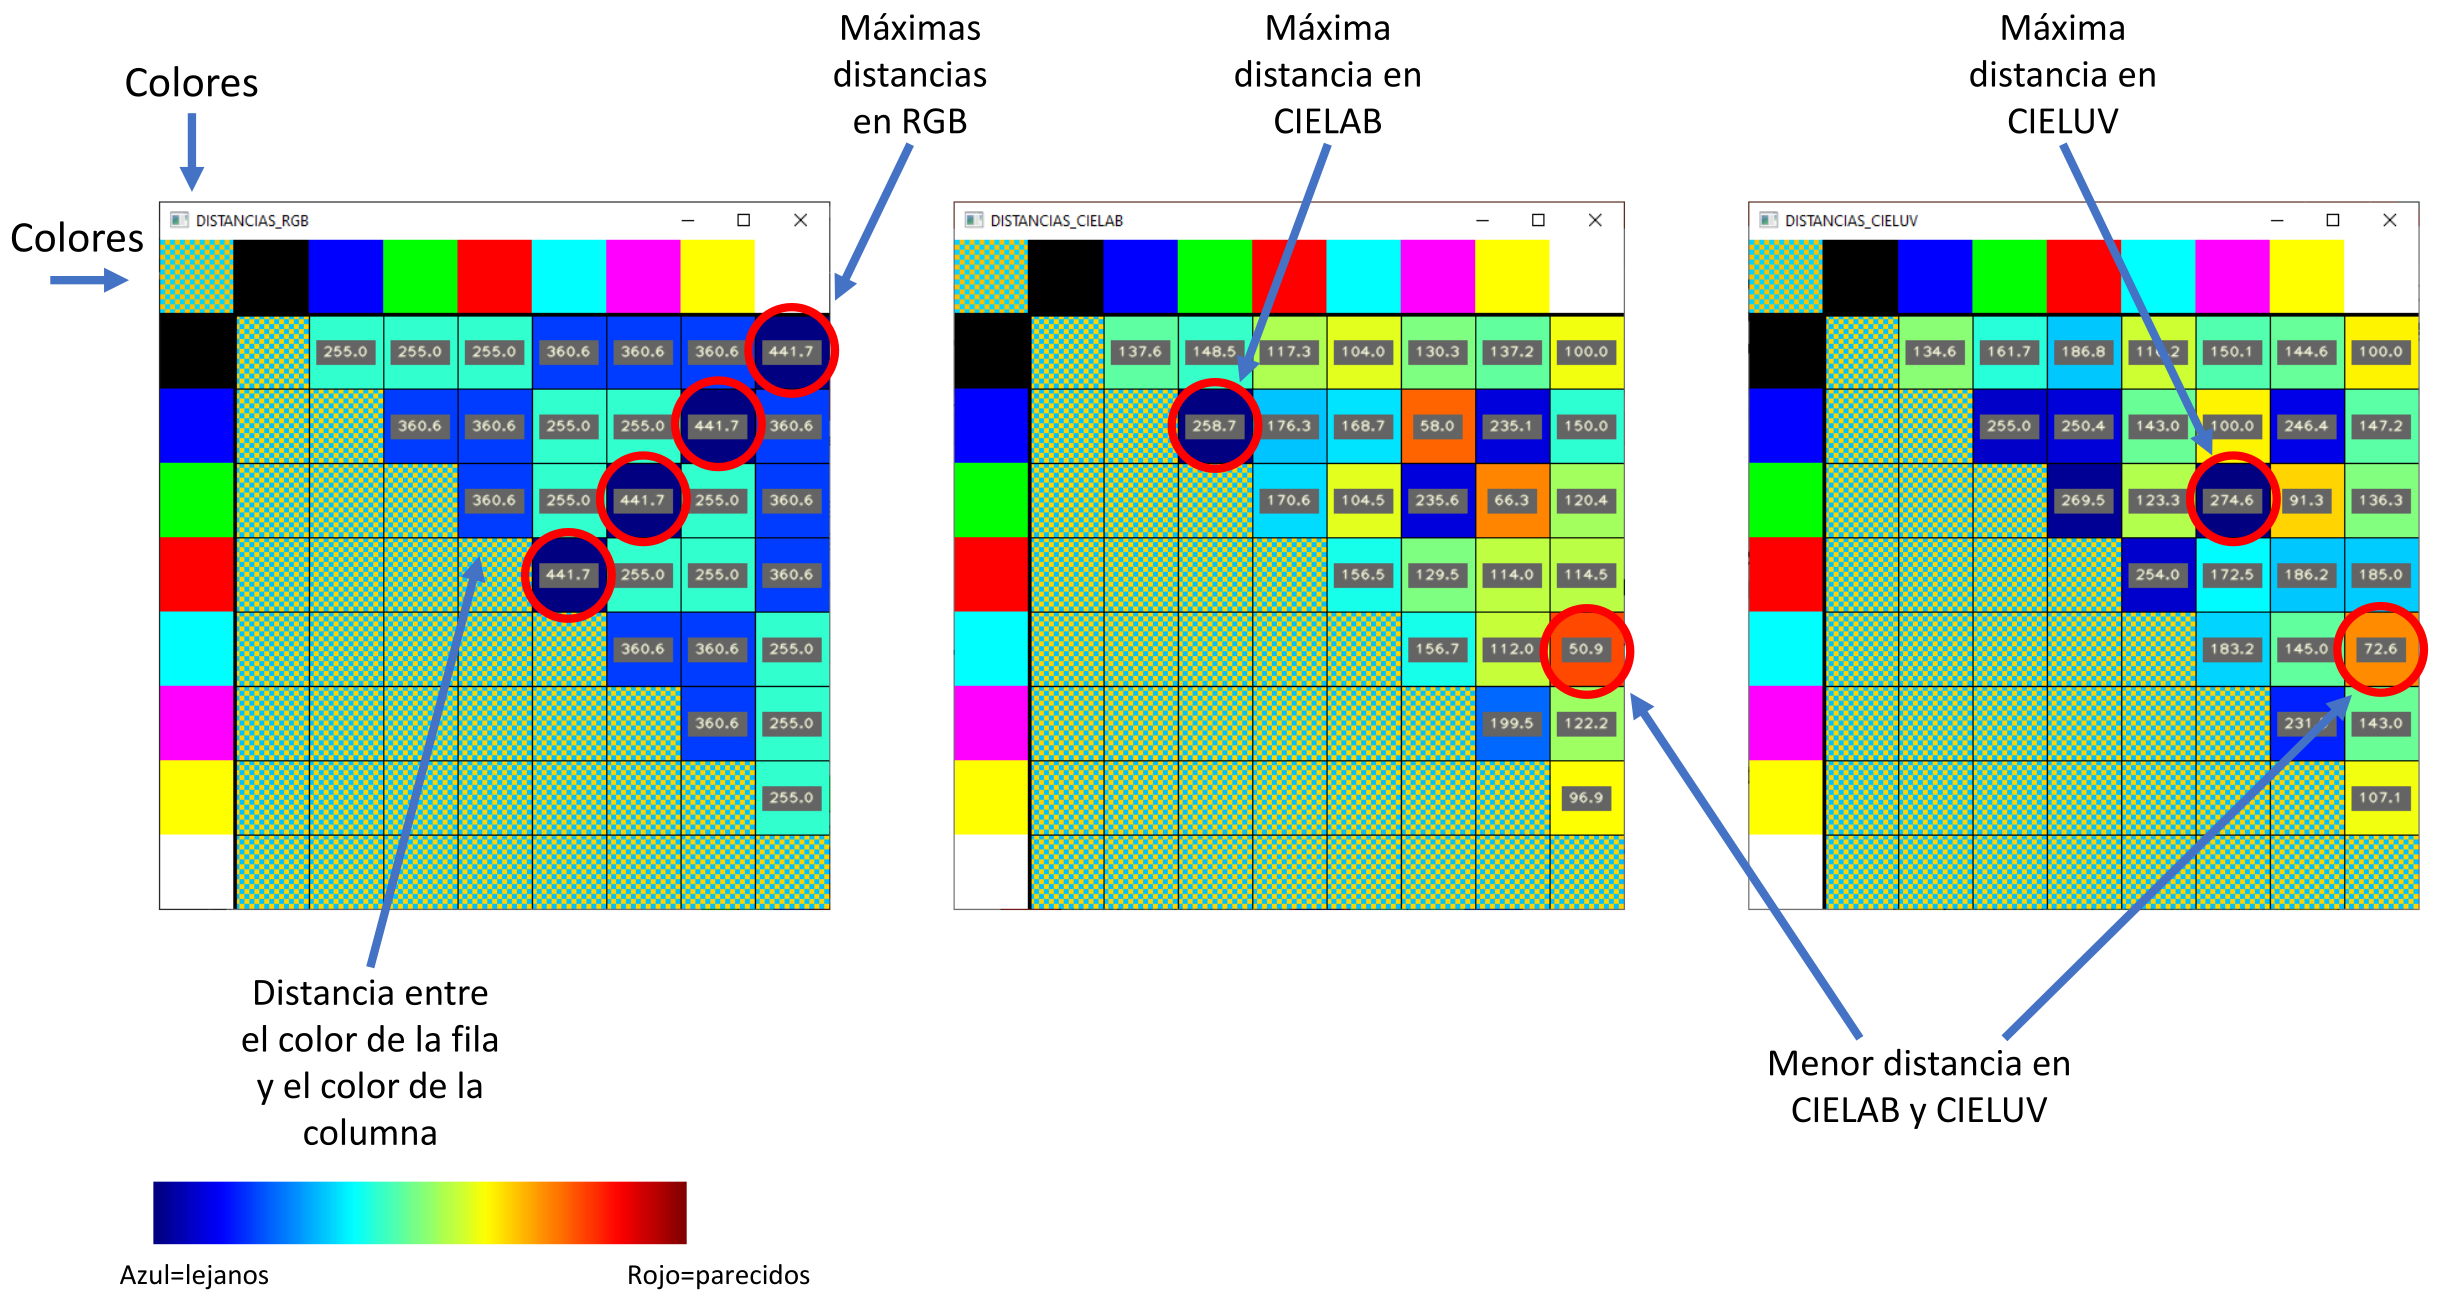

In [1]:
from IPython.display import Image

Image(filename = "resultado_comparacion.png")

# Comparando otros colores

Es interesante comparar colores que son relativamente parecidos, para ver cual se asemeja más a la opinión de una persona.

**¿Cuál espacio de color se acerca más a tu opinión del color más parecido?**

In [ ]:
def ejemplo_2():
    lista1 = list()
    lista1.append(Color("Rojo Mate",  193,  68,  14))
    lista1.append(Color("Azul Mate",   72,  99, 160))
    lista1.append(Color("Verde Lima",  50, 205,  50))
    lista2 = list()
    lista2.append(Color("Verde Claro",   144, 238, 144))
    lista2.append(Color("Azul Celeste",  135, 206, 235))
    lista2.append(Color("Oro Brillante", 255, 215,   0))
    lista2.append(Color("Rosa Pastel",   255, 209, 220))
    # se comparan los dos grupos de colores
    comparar_colores(lista1, lista2, block_size = 80)

# comparacion entre algunos colores
ejemplo_2()
